Source: https://www.kaggle.com/code/emmanuelfwerr/xgboost-multi-class-classification

# Multi-class Classification with XGBoost

## Table of Contents
* [Introduction](#section-one)
* [Preliminary Research](section-two)
* [Exploratory Data Analysis](section-three)
* [Handling Inconsistencies](#section-four)
    - [Investigating Outliers](#subsection-one)
    - [Investgating Missing Values](#anything-you-like)
* [XGBoost Classifier](#section-five)
* [Conclusion](#section-six)

## Introduction

The aim of this notebook is using XGBoost to classify patients with different types of thyroid related disease given their age, sex, and medical information – including test results for thyroid hormone levels in blood. The data was obtained from [this UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/thyroid+disease). The repository contains several text files with different subsets of the data. One of them contains information for ~9000 unique patients along with a medical diagnosis out of 20 possible classes. Those classes make up 7 distinct diagnosis types:
- `negative diagnosis`
- `hyperthyroid conditions`
- `hypothyroid conditions`
- `binding protein`
- `non-thyroidal`
- `undergoing replacement therapy`
- `discordant results`

The different target diagnoses were mapped to one of these classes at the moment import to the notebook. Some inconclusive diagnoses were dropped given that they make up less than 3% of all cases present in the dataset.

Moving forward with the analysis it has been decided to only keep the observations for patients with diagnosis either `negative`, `hyperthyroid`, or `hypothyroid`. This is because they are the most prevalent observations and the focus of this project. The other classes were dropped from the dataset upon import and thus we are left with ~7500 unique entries in the dataset.
- The main reason for dropping the other classes is that they are not important to our focus because either they dont relate thyroid disease per-se (for example `non-thyroidal`, `discordant results`), or they refer to a treatment (for example `undergoing replacement therapy`).
- Another big, probably more important, reason is that they create niose in our data.
    - Our most important attributes are the blood test results of hormone levels. The other target classes referring to treatments and other conditions blurr barriers between classes. We believe they belong in a different analysis with a slightly different focus.
    

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---
## Preliminary Research

Before beginning our analysis, it is important to understand the subject and nature of our data.
- What is Thyroid Disease?
- What is TSH measurement? What are scientifically established normal values?
    - A high TSH level indicates that the thyroid gland is not making enough thyroid hormone (primary hypothyroidism). On the other hand, a low TSH level usually indicates that the thyroid is producing too much thyroid hormone (hyperthyroidism). 
        - TSH normal values are 0.5 to 5.0 mIU/L
- What is T3 measurement? What are scientifically established normal values?
    - A Total T3 test measures the bound and free fractions of triiodothyronine. Hyperthyroid patients typically have an elevated Total T3 level. T3 tests can be used to support a diagnosis of hyperthyroidism and can determine the severity hyperthyroidism.
        - A normal Total T3 level in adults ranges from 80-220 ng/dL
- What is TT4 measurement? What are scientifically established normal values?
    - A Total T4 test measures the bound and free thyroxine (T4) hormone in the blood. Total T4 levels are affected by medications and medical conditions that change thyroid hormone binding proteins. Estrogen, oral contraceptive pills, pregnancy, liver disease, and hepatitis C virus infection are common causes of increased thyroid hormone binding proteins and will result in a high Total T4. Oppositely, Testosterone or androgens and anabolic steroids are common causes of decreased thyroid hormone binding proteins and will result in a low Total T4.
        - A normal Total T4 level in adults ranges from 5.0 to 12.0μg/dL
- What is T4U measurement? What are scientifically established normal values?
    - T4U tests measure thyroxine (T4) utilization rate in the body. They can help measure how well the body is utilizing T4 hormone.
- What is FTI measurement? What are scientifically established normal values?
    - A Free T4 Index measures what is not bound and able to freely enter and affect the body tissues. Tests measuring free T4 index (FTI) usually more accurately reflect how the thyroid gland is functioning.
        - FT4 normal values are 0.7 to 1.9ng/dL

We do not know the units that the different hormone blood measurements in our dataset use. But knowing about what these levels are usually for individuals can help us tremendously in understanding our dataset. As well as making hypothesis of the units that are used in the dataset and detecting Outliers/inconsistencies.

Now that we have this information, let us begin with the analysis.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # deluxe visualization library
import matplotlib.pyplot as plt # visualization library to support seaborn
%matplotlib inline

# importing dataset from persistent landing
thyroidDF = pd.read_csv('./thyroidDF.csv') # thyroidDF.csv

# dropping redundant attributes from thyroidDF dataset
thyroidDF.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'patient_id', 'referral_source'], axis=1, inplace=True)

# re-mapping target vaues to diagnostic groups
diagnoses = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'E': 'hypothyroid', 
             'F': 'hypothyroid', 
             'G': 'hypothyroid', 
             'H': 'hypothyroid'}

thyroidDF['target'] = thyroidDF['target'].map(diagnoses) # re-mapping
# dropping observations with 'target' null after re-mapping
thyroidDF.dropna(subset=['target'], inplace=True) 

# dataset initial summary
thyroidDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7546 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7546 non-null   int64  
 1   sex                  7296 non-null   object 
 2   on_thyroxine         7546 non-null   object 
 3   query_on_thyroxine   7546 non-null   object 
 4   on_antithyroid_meds  7546 non-null   object 
 5   sick                 7546 non-null   object 
 6   pregnant             7546 non-null   object 
 7   thyroid_surgery      7546 non-null   object 
 8   I131_treatment       7546 non-null   object 
 9   query_hypothyroid    7546 non-null   object 
 10  query_hyperthyroid   7546 non-null   object 
 11  lithium              7546 non-null   object 
 12  goitre               7546 non-null   object 
 13  tumor                7546 non-null   object 
 14  hypopituitary        7546 non-null   object 
 15  psych                7546 non-null   object

In [5]:
# distributions of numeric variables
thyroidDF.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,7546.000000,6824.000000,5337.000000,7192.000000,6870.000000,6877.000000,259.000000
mean,78.013782,5.421753,2.020935,105.203373,0.967322,110.571745,22.955019
std,1305.258137,26.080471,0.809865,32.606462,0.162315,36.600867,6.088392
min,1.000000,0.005000,0.050000,2.000000,0.190000,1.400000,0.100000
25%,37.000000,0.570000,1.600000,87.000000,0.870000,93.000000,20.000000
50%,55.000000,1.400000,2.000000,103.000000,0.960000,108.000000,23.000000
75%,67.000000,2.700000,2.300000,121.000000,1.060000,125.000000,27.000000
max,65526.000000,530.000000,18.000000,430.000000,2.120000,839.000000,45.000000


### Initial Thoughts

The columns listed below were removed because of redundacy. They are boolean and state whether or not a value has been recorded for their respective blood tests. If a value has been recorded for a blood test, it will be present in its column. Otherwise, it will be null.
- `TSH_measured`
- `T3_measured`
- `TT4_measured`
- `T4U_measured`
- `FTI_measured`
- `TBG_measured`

The `patient_id` attribute was also removed after checking for duplicate observations because it provides no use to us moving forward.

**Observations:**
- Max `age` value is 65,526 years old. Either that person is really really old or this is a mistake. There are likely more inconsistencies like this one throughout the data.
    - Persons with age above 100 will be removed since they have `target` negative and we wont be losing to much information by omitting them
- Some Max values for Thyroid Hormone tests looks suspicious.
    - We will investigate with these later while detecting and handling outliers

In [7]:
# inspecting observations with age > 100
thyroidDF[thyroidDF.age > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,target
2976,455,F,f,f,f,f,f,f,f,f,...,f,f,f,1.10,2.0,118.0,1.13,104.0,NaN,negative
5710,65511,M,f,f,f,f,f,f,f,f,...,f,f,f,0.38,2.0,113.0,1.08,104.0,NaN,negative
6392,65512,M,f,f,f,f,f,f,f,f,...,f,f,f,0.03,2.8,112.0,0.84,133.0,NaN,negative
8105,65526,F,f,f,f,f,f,f,f,f,...,f,f,f,1.50,NaN,132.0,1.02,129.0,NaN,negative


In [8]:
# changing age of observations with ('age' > 100) to null
thyroidDF['age'] = np.where((thyroidDF.age > 100), np.nan, thyroidDF.age)

---
## Exploratory Data Analysis

We begin our EDA by looking at the distribution of Hormone levels in blood for each of our target classes. This helps us get an idea for how good of a predictor each of these attributes can be

<Axes: xlabel='target', ylabel='TBG'>

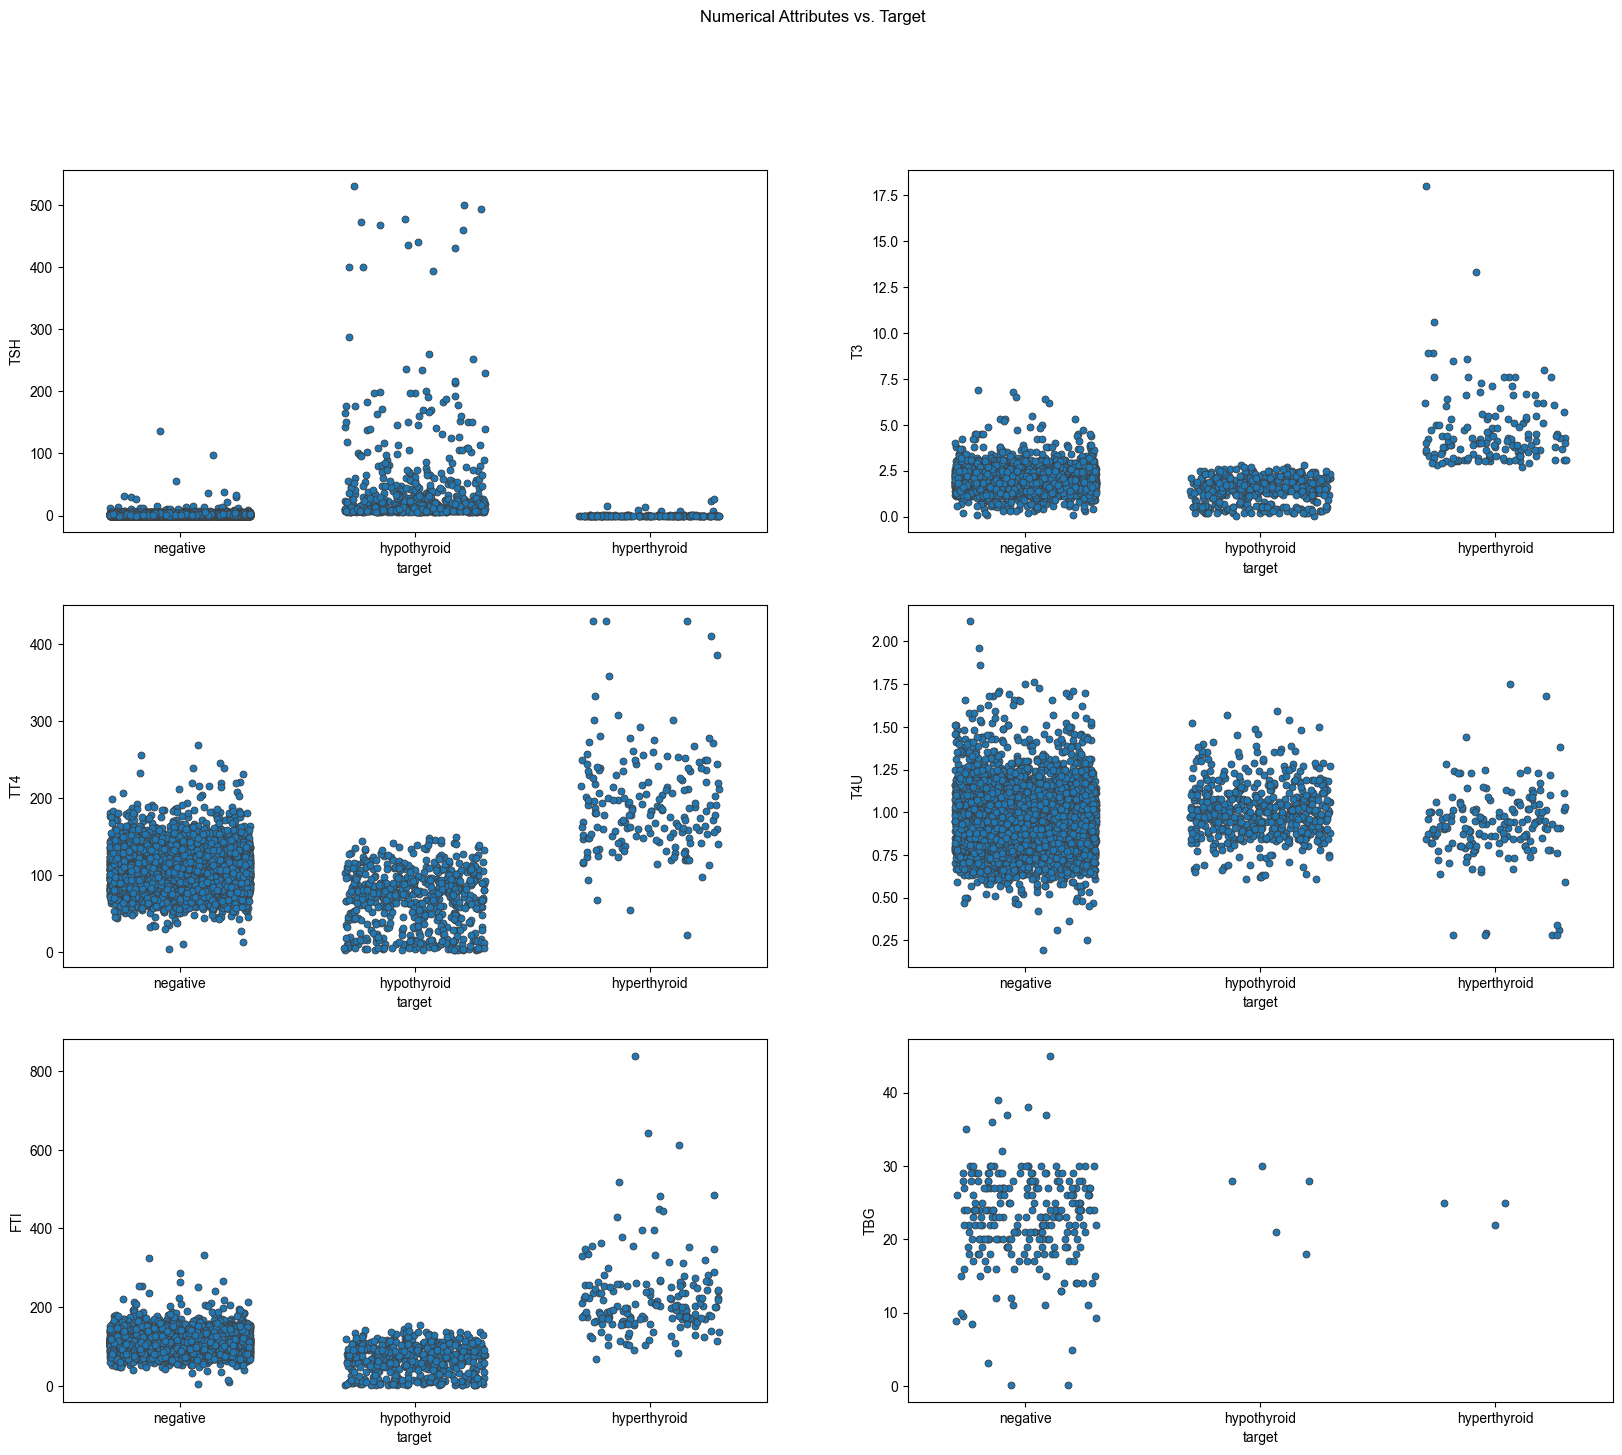

In [9]:
# setting up grid for multiple seaborn plots
fig, axes = plt.subplots(3,2,figsize=(20,16))
fig.suptitle('Numerical Attributes vs. Target')
sns.set_style('whitegrid');

# TSH vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.T4U, linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.FTI, linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
# TBG vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TBG, linewidth=0.6, jitter= 0.3, ax=axes[2, 1])

**Observations:**
- Immediately we can hypothesize that `FTI`, `T3`, and `TT4` will be good feature additions to our models. `TSH` looks like it might be good as well but we need to handle the outliers for `'target'` hypo and analyze the attribute distribution further before making any decisions.
    - This is all in-line with the knowledge discovered about Hormone level tests during our initial research

Let's continue by creating a pairplot of our numeric variables and seeing if we can spot any clusters forming between variables.

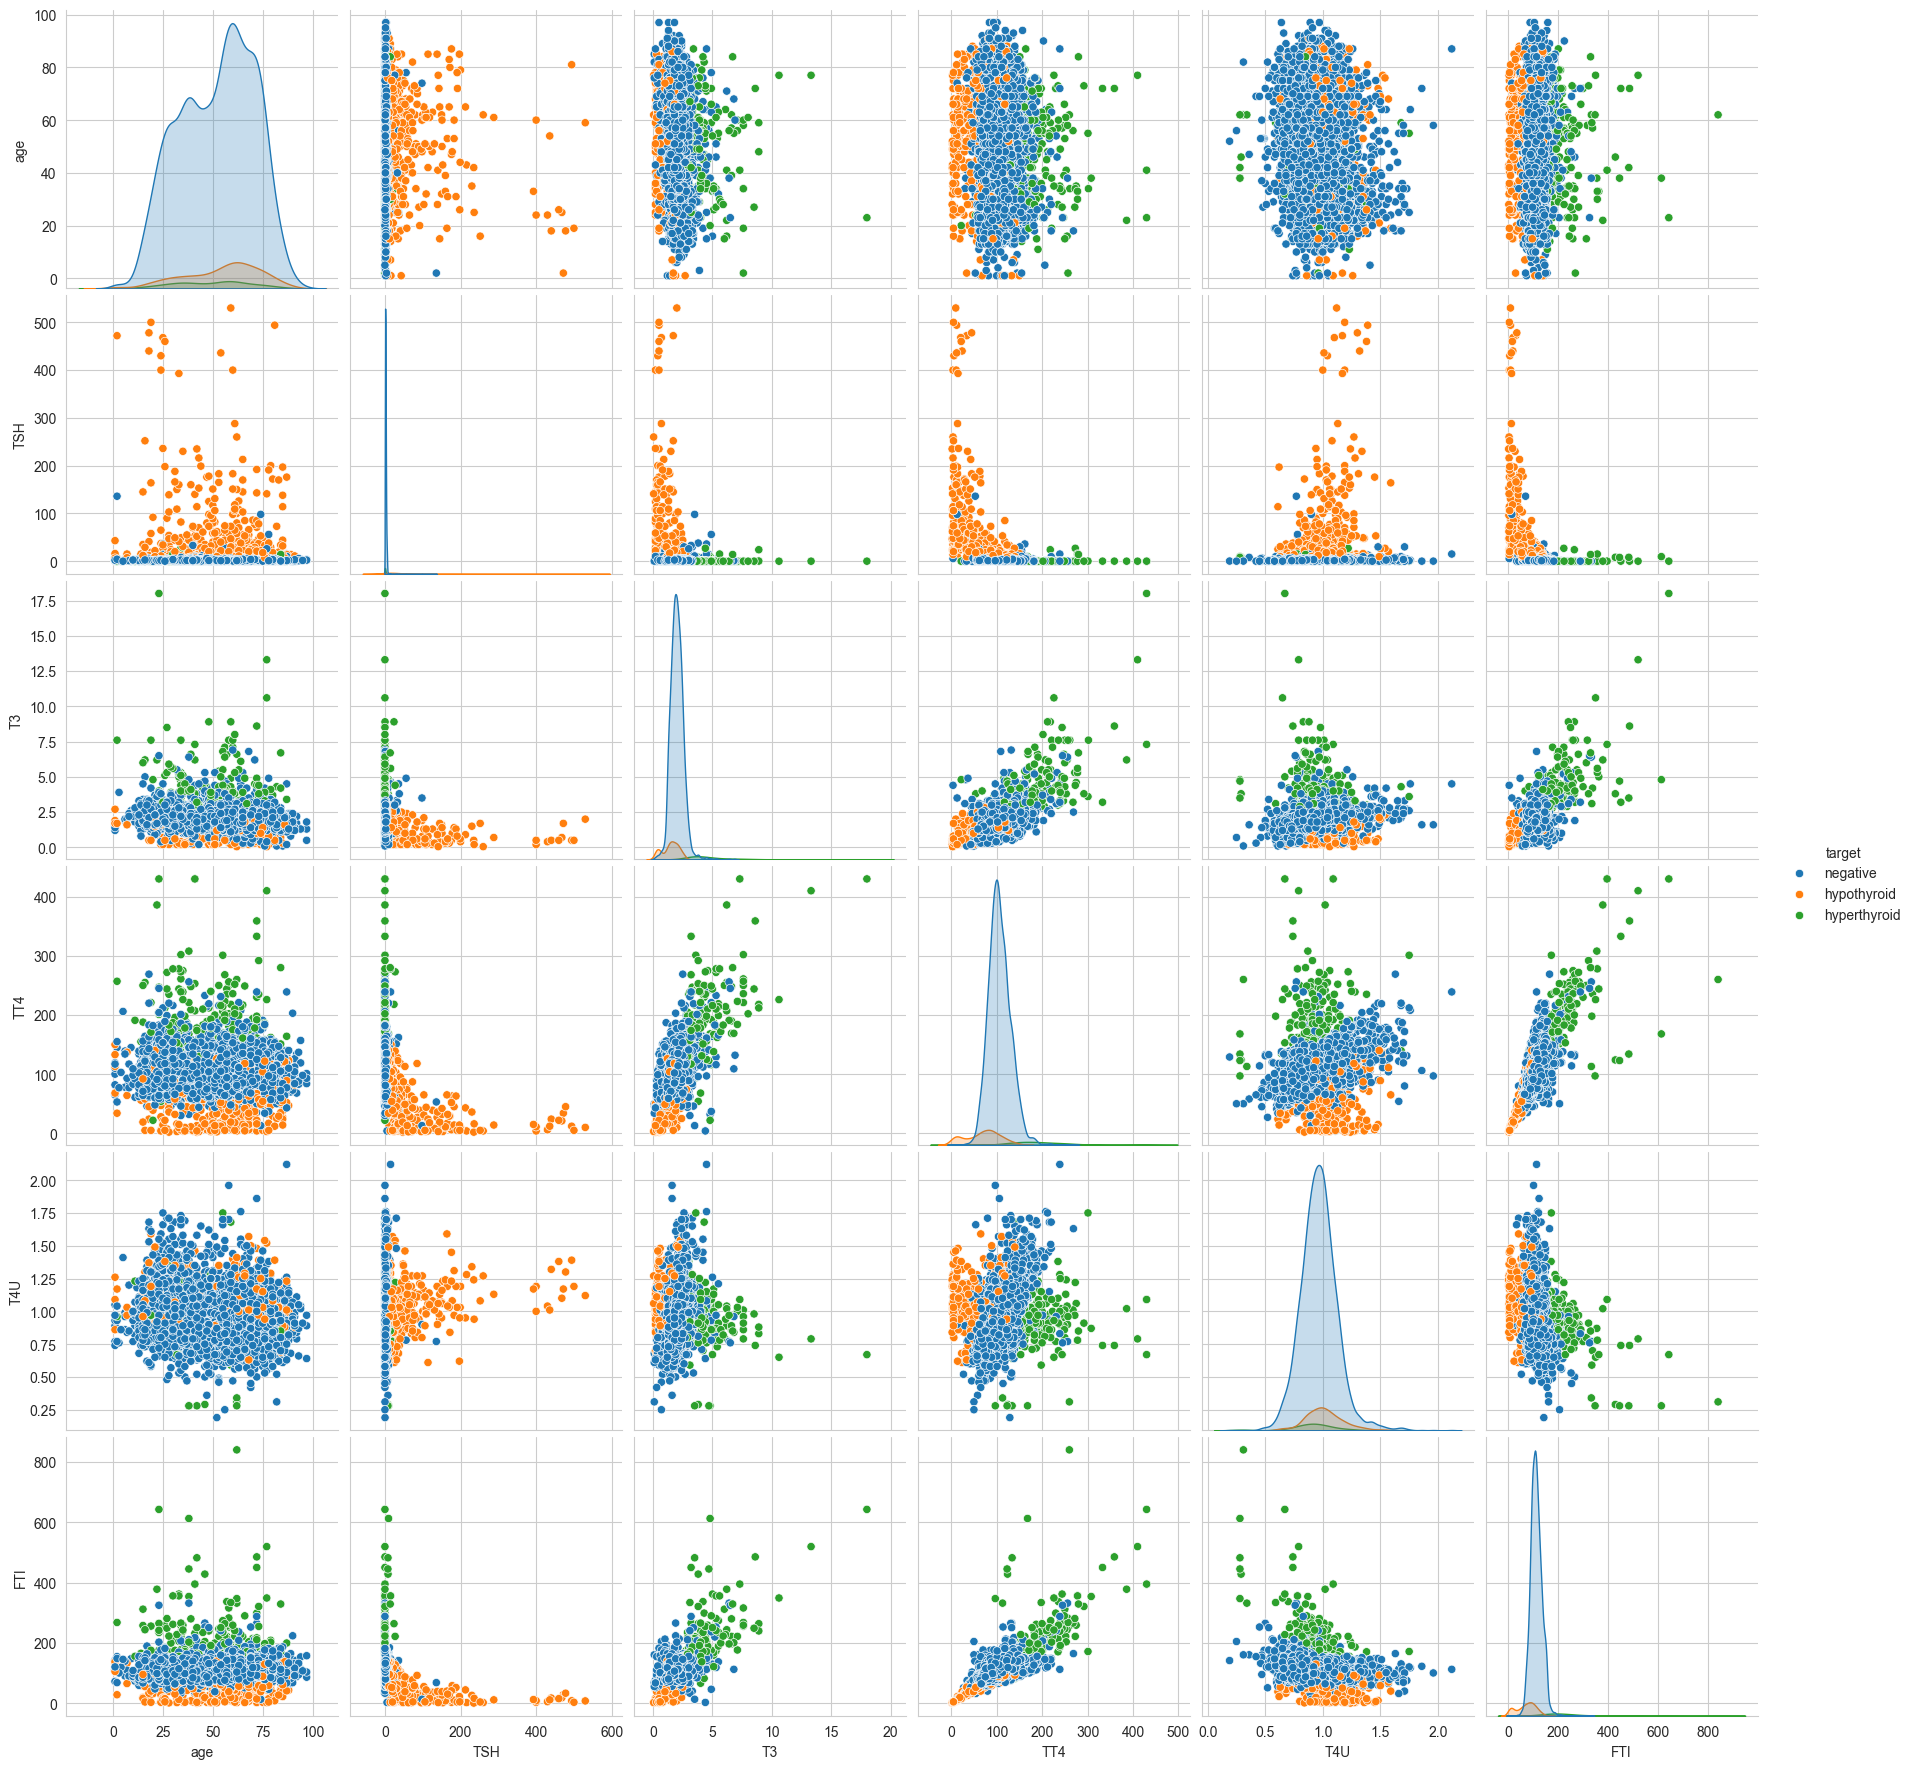

In [10]:
numericalDF = thyroidDF[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']].copy()
sns.set_style('whitegrid');
sns.pairplot(numericalDF, hue='target', height=3);
plt.show()

In the diagonals of the pairplot we can see the distributions of each numeric variable with respect to one another. It is apparent how unbalanced the dataset is, with so many negative 'target' compared to hypothyroid or hyperthyroid.

**Observations:**
- We can see that for some Hormone test vs others there are nice clusters that form. This is encouragin because it means that they do a good job at separating out each of our target classes.
    - `FTI` vs `T3`
    - `FTI` vs `T4U`
    - `FTI` vs `age`
    - `T4U` vs `TT4`
    - `TT4` vs `age`
    - `TT4` vs `T3`
- There is severe target class imbalance... but we knew this from the start. It is normal for this type of data. We will have to treat with resampling protocol as well as using models that handle this well
    - XGBoost would be a good option

### Investigating Feature Correlations

Now lets give some love to our other bolean attributes and take a look at the correlation between all of our attributes between one another.

- We are using package `dython` as a multi-variate correlation exploration tool. This is not necessarily the most thorough way to explore relationships between variables of different types within your dataset, but it is straight-forward and easy to use. It will help us get an idea of variable correlations later on while performing Exploratory Data Analysis.

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\noors\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


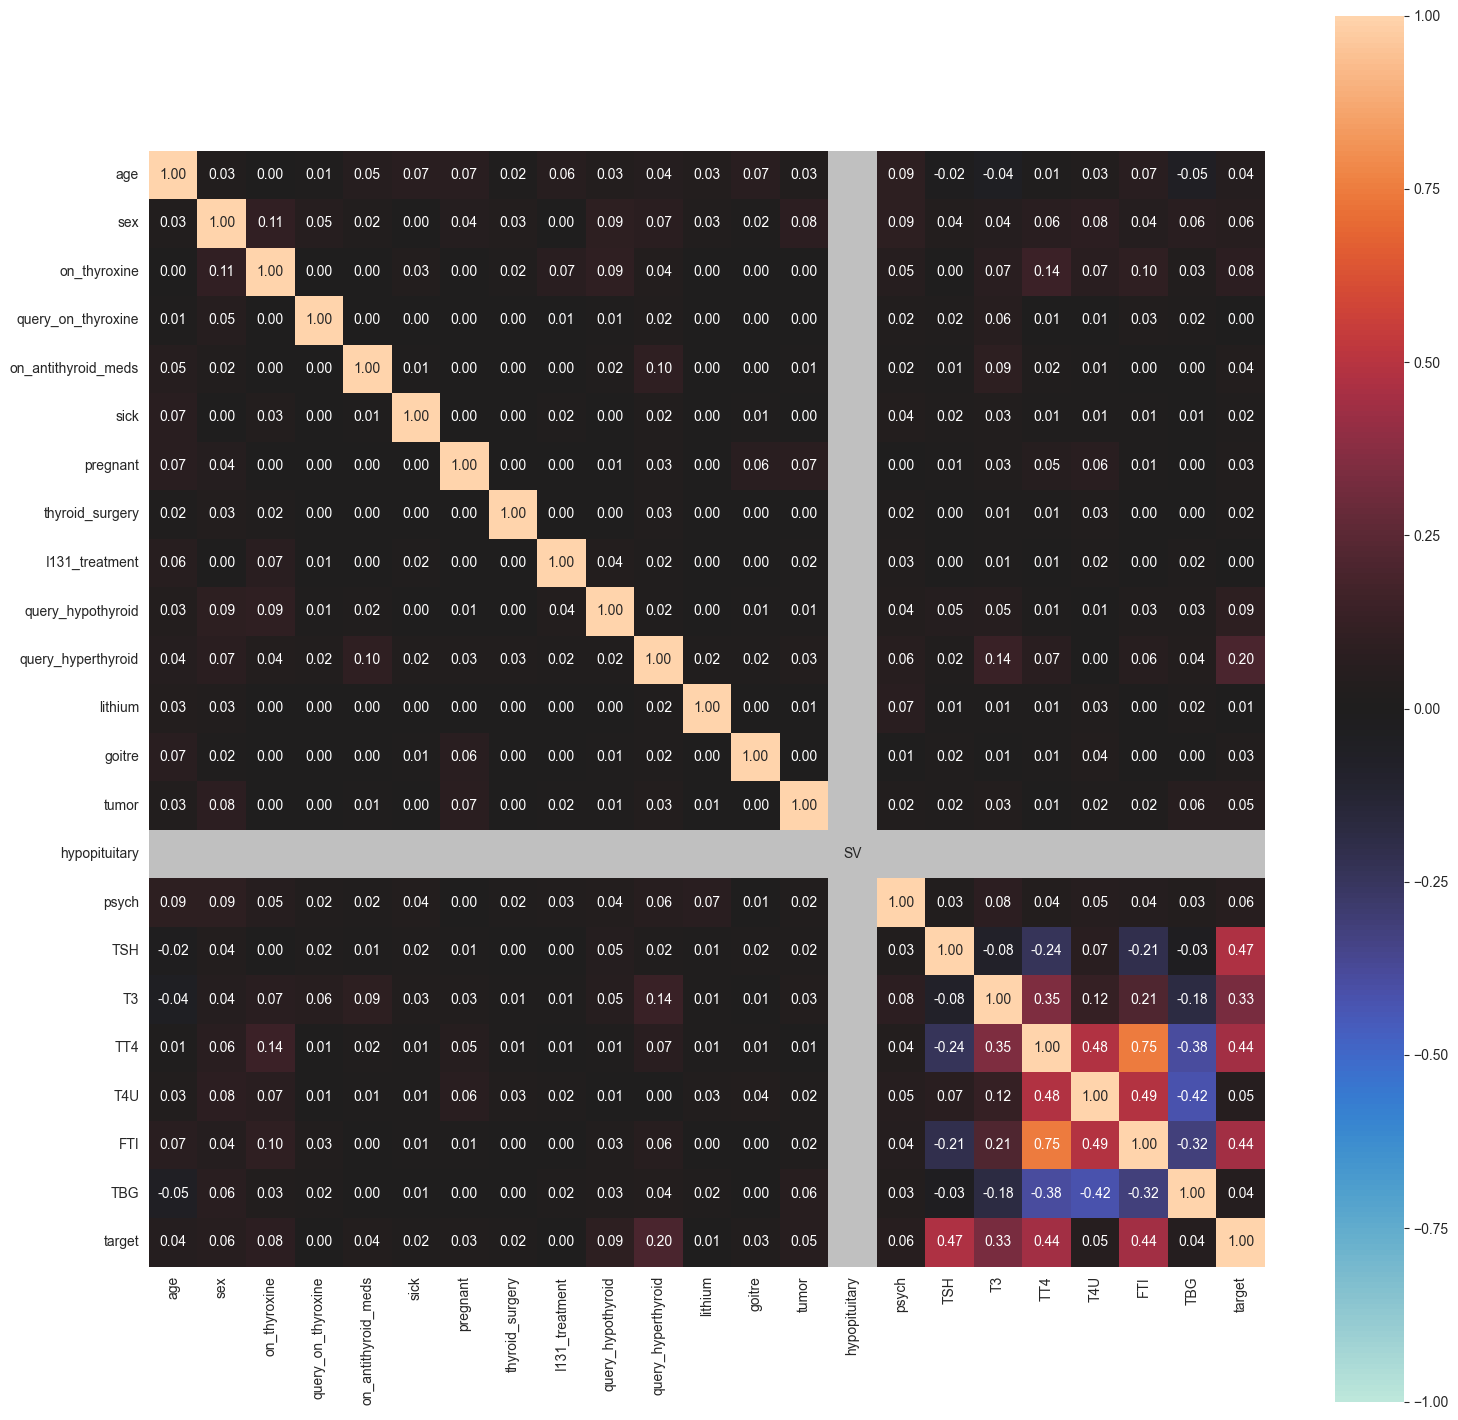

In [11]:
!pip install dython
import dython
from dython.nominal import associations
from dython.nominal import identify_nominal_columns

categorical_features = identify_nominal_columns(thyroidDF)

associations(thyroidDF, 
            nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson',  
            ax=None, annot=True, fmt='.2f',cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, 
            compute_only=False, clustering=False, title=None, filename=None, 
            figsize=(18,18));

Very nice to have all this information about the correlation of all our attributes in the same place. Immediately we confirm our hypothesis that the Hormone tests are the most helpful in our aim to predict target diagnosis. Surprising though that almost no other of our attributes do a good job at predicting our target. We will decide how to move on with this when we analyze a bit more.

**Observations:**
- c

---
## Handling Inconsistencies

### Investigating Outliers

The code below calculates the Inter-quartile ranges for our Hormone test numeric attributes in order to determin mild and sever outliers. Depending on the severity of the issue we will decide how to handle them in the next section.

In [12]:
# TSH
Q1_TSH = thyroidDF['TSH'].quantile(0.25)
Q3_TSH = thyroidDF['TSH'].quantile(0.75)
IQR_TSH = Q3_TSH - Q1_TSH
under_TSH = thyroidDF['TSH'] < (Q1_TSH - 3 * IQR_TSH)
upper_TSH = thyroidDF['TSH'] > (Q3_TSH + 3 * IQR_TSH)
print('TSH:', 'lower outliers -', sum(under_TSH), ' | upper outliers -', sum(upper_TSH))

# T3
Q1_T3 = thyroidDF['T3'].quantile(0.25)
Q3_T3 = thyroidDF['T3'].quantile(0.75)
IQR_T3 = Q3_T3 - Q1_T3
under_T3 = thyroidDF['T3'] < (Q1_T3 - 3 * IQR_T3)
upper_T3 = thyroidDF['T3'] > (Q3_T3 + 3 * IQR_T3)
print('T3:', 'lower outliers -', sum(under_T3), ' | upper outliers -', sum(upper_T3))

# TT4
Q1_TT4 = thyroidDF['TT4'].quantile(0.25)
Q3_TT4 = thyroidDF['TT4'].quantile(0.75)
IQR_TT4 = Q3_TT4 - Q1_TT4
under_TT4 = thyroidDF['TT4'] < (Q1_TT4 - 3 * IQR_TT4)
upper_TT4 = thyroidDF['TT4'] > (Q3_TT4 + 3 * IQR_TT4)
print('TT4:', 'lower outliers -', sum(under_TT4), ' | upper outliers -', sum(upper_TT4))

# T4U
Q1_T4U = thyroidDF['T4U'].quantile(0.25)
Q3_T4U = thyroidDF['T4U'].quantile(0.75)
IQR_T4U = Q3_T4U - Q1_T4U
under_T4U = thyroidDF['T4U'] < (Q1_T4U - 3 * IQR_T4U)
upper_T4U = thyroidDF['T4U'] > (Q3_T4U + 3 * IQR_T4U)
print('T4U:', 'lower outliers -', sum(under_T4U), ' | upper outliers -', sum(upper_T4U))

# FTI
Q1_FTI = thyroidDF['FTI'].quantile(0.25)
Q3_FTI = thyroidDF['FTI'].quantile(0.75)
IQR_FTI = Q3_FTI - Q1_FTI
under_FTI = thyroidDF['FTI'] < (Q1_FTI - 3 * IQR_FTI)
upper_FTI = thyroidDF['FTI'] > (Q3_FTI + 3 * IQR_FTI)
print('FTI:', 'lower outliers -', sum(under_FTI), ' | upper outliers -', sum(upper_FTI))

TSH: lower outliers - 0  | upper outliers - 456
T3: lower outliers - 0  | upper outliers - 84
TT4: lower outliers - 0  | upper outliers - 55
T4U: lower outliers - 7  | upper outliers - 22
FTI: lower outliers - 0  | upper outliers - 83


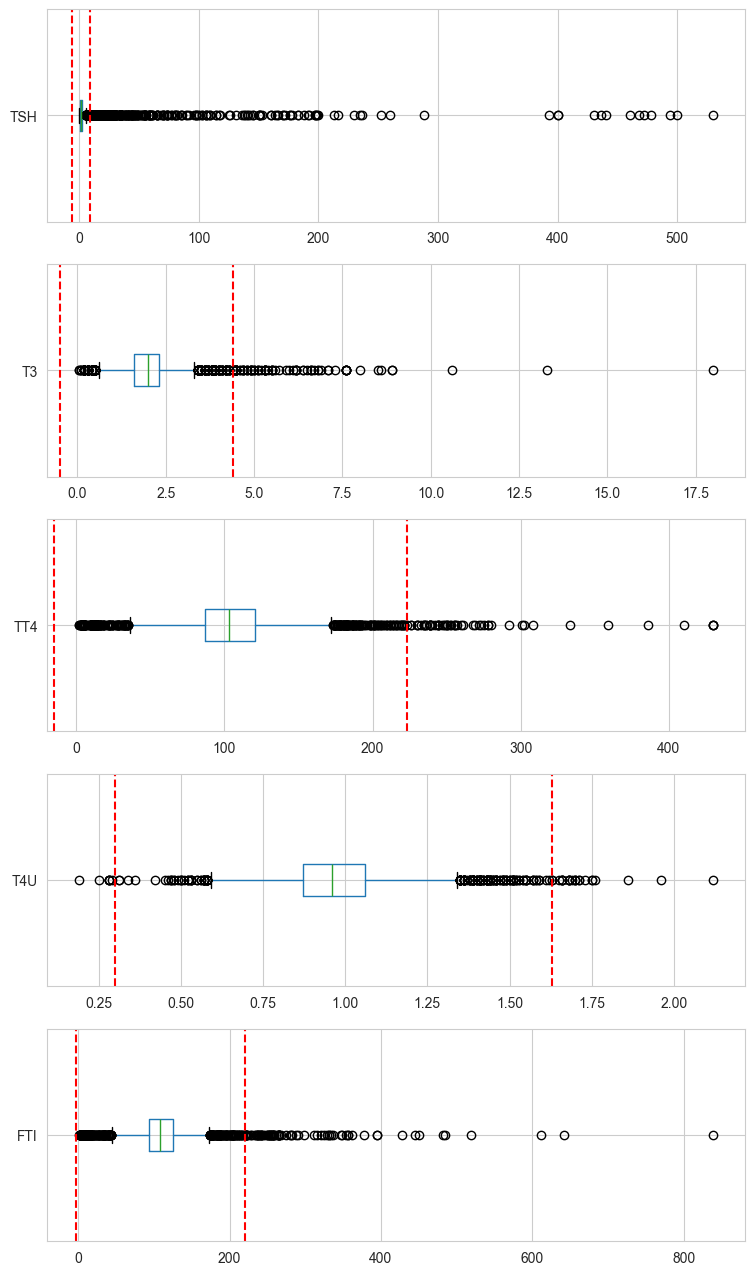

In [13]:
# preparing boxplots
fig, axs= plt.subplots(nrows = 5, figsize=(9,16))

# TSH
thyroidDF.boxplot(column='TSH', ax=axs[0], vert = False)
axs[0].axvline(x=(Q1_TSH - 3*IQR_TSH), color='r', linestyle='--')
axs[0].axvline(x=(Q3_TSH + 3*IQR_TSH), color='r', linestyle='--')
# T3
thyroidDF.boxplot(column='T3', ax=axs[1], vert = False)
axs[1].axvline(x=(Q1_T3 - 3*IQR_T3), color='r', linestyle='--')
axs[1].axvline(x=(Q3_T3 + 3*IQR_T3), color='r', linestyle='--')
# TT4
thyroidDF.boxplot(column='TT4', ax=axs[2], vert = False)
axs[2].axvline(x=(Q1_TT4 - 3*IQR_TT4), color='r', linestyle='--')
axs[2].axvline(x=(Q3_TT4 + 3*IQR_TT4), color='r', linestyle='--')
# T4U
thyroidDF.boxplot(column='T4U', ax=axs[3], vert = False)
axs[3].axvline(x=(Q1_T4U - 3*IQR_T4U), color='r', linestyle='--')
axs[3].axvline(x=(Q3_T4U + 3*IQR_T4U), color='r', linestyle='--')
# FTI
thyroidDF.boxplot(column='FTI', ax=axs[4], vert = False)
axs[4].axvline(x=(Q1_FTI - 3*IQR_FTI), color='r', linestyle='--')
axs[4].axvline(x=(Q3_FTI + 3*IQR_FTI), color='r', linestyle='--')

It seems that we have many severe outliers present. However, given our research about these values, this type of variance is normal within this context and is to be expected, especially when dealing with persons who will have alterations in these  values given their medical conditions.

### Investigating Missing Values

First we will do some calculations to determine the severity of our missing value problem. The custom function below takes a dataframe as input and keeps a tally of missing values per column, then calculates the percentage of missing values in that column and summarizes the information in an output dataframe that is easy for us to viasualize.

- The overall missingess of our dataset is **7.54%**
    - This seems worrying at first but most of that bulk is because of the TBG column which is almost entirely empty. We knew we were dropping this from the start of the analysis but have kept it for exploration purposes. Now it is time to go for it.
- `T3` is second most missing column at **29.3%** 
    - This is a lot of missing data and it might be adviseable to remove but the column is too important for our analysis (we have also done separate research that has reiterated that T3 is a very important predictor for thyroid disease). We will try to impute this information moving forward.
- `TSH` is third most missing column at **9.56%**
    - This is a good candidate for imputation moving forward
- `FTI` is our fourth most missing column at **8.86%**
    - This is also a good candidate for imputation
- `TT4` is our fifth most missing column at **4.69%**
    - Once again a good candidate for imputation
- `sex` is our sixth most missing column at **3.31%**
    - We will determine what to do with sex later on
        - depending on how important it is to keep in our dataset for modeling purposes we will attempt to impute
- `age` has 4 missing values
    - we created these values by removing the inconsistent (very large) age for these observation
        - we determined we can go ahead and drop these observations without impacting our analysis

**Observations:**
-  It doesnt seem lke a coincidence that most missing values present are from blood tests
    - We need to investigate this further in order to decide the best approach to handling them
        - Are they not there because they weren't properly recorded or because they were never ordered to be taken (deemed not necessary by doctors)?
    - We will determine what to do with sex later on
        - depending on how important it is to keep in our dataset for modeling purposes we will attempt to impute
- `age` has 4 missing values
    - we created these values by removing the inconsistent (very large) age for these observation
        - we determined we can go ahead and drop these observations without impacting our analysis

In [14]:
# calculating missingess of entire DF
missingness = thyroidDF.isnull().sum().sum() / thyroidDF.count().sum()
print('Overall Missingness of thyroidDF is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(thyroidDF).head(10)

Overall Missingness of thyroidDF is: 7.54%


,Total,Percent
TBG,7287,0.965677
T3,2209,0.292738
TSH,722,0.095680
T4U,676,0.089584
FTI,669,0.088656
TT4,354,0.046912
sex,250,0.033130
age,4,0.000530
goitre,0,0.000000
psych,0,0.000000


### Missing Table Summary

**thyroidDF[`'TBG'`]** – 96.56% missing
- The 'TBG' attribute is almost entirely missing from the dataset. This column will be removed at once!

**thyroidDF[`'age'`]** – 0.045% missing
- We will also go ahead and drop these 4 observations from the dataset. All 4 of these observations belong to observations with 'target' == 'negative'

**thyroidDF[`'Sex'`]** – 3.37% missing
- There are a total of 300 observations where 'sex' is null. In an attempt to preserve some of these values, we check how many of these observations also have 'pregnant' == True. There are 3 such observations. Assuming the 'pregnancy' attribute is correct for these observations, we can confidently say these 3 observations belong to women and can change their respective values.

In [15]:
# dropping 'TBG' attribute from dataset
thyroidDF.drop(['TBG'], axis=1, inplace=True)

# dropping 4 observations with abnormal 'age' from dataset
thyroidDF.dropna(subset=['age'], inplace=True)

# changing sex of observations with ('pregnant' == True) & ('sex' == null) to Female
thyroidDF['sex'] = np.where((thyroidDF.sex.isnull()) & (thyroidDF.pregnant == 't'), 'F', thyroidDF.sex)

Now lets take a look at missing values per row. If we are moving forward with imputation, we dont want to keep rows that have too many missing values (especially since most missing values in the dataset are from the most important attributes). 

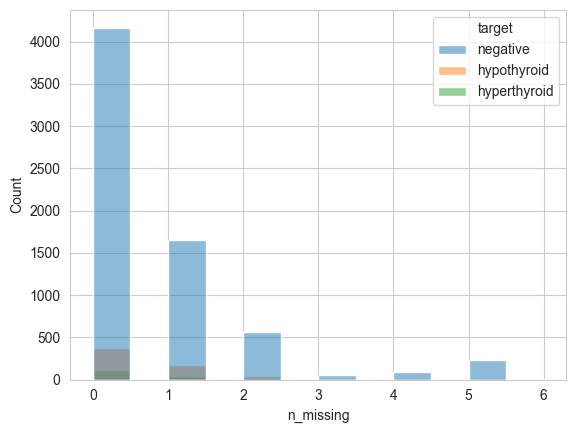

In [16]:
# count missing values per row
thyroidDF['n_missing'] = thyroidDF.isnull().sum(axis=1)
sns.histplot(thyroidDF, x='n_missing', binwidth=0.5, hue='target');

It looks like after removing `TBG` from the dataset, most of the observations in our dataset have zero missing values. A lot have one missing value and some have two. a minority have 3 or more. Before we do any imputation we will remove the observations that are missing data for more than 2 columns. This is because we dont want to make up observations alltogether. We do this removal in the code below, as well as generate a final table for missing values after we handled most of them.

We are now at only 2.89% missing data throughout the dataset overall!

In [17]:
# calculating missingess of entire DF
missingness = thyroidDF.isnull().sum().sum() / thyroidDF.count().sum()
print('Overall Missingness of thyroidDF is: {:.2f}%'.format(missingness * 100))

# remove rows with 3 or more missing values
thyroidDF.drop(thyroidDF.index[thyroidDF['n_missing'] > 2], inplace=True)
print
missing_table(thyroidDF).head(10)

Overall Missingness of thyroidDF is: 2.89%


,Total,Percent
T3,1910,0.267432
TSH,406,0.056847
T4U,290,0.040605
FTI,283,0.039625
sex,208,0.029123
TT4,6,0.000840
age,0,0.000000
goitre,0,0.000000
target,0,0.000000
psych,0,0.000000


---
## XGBoost Classifier

XGBoost has some amazing properties that make it extremely suitable for our data: 
- It can natively handle missing values in data as long as we encode them with 0.
- It does a great job at handling severe imbalance of classes
    - especially with its `sample_weight` parameter to help counter heavy target class imbalance
- It can select the most important features needed during training and uses those for its tree building

### Preprocessing for XGBoost

In [19]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

# replacing boolean strings with binary 0 and 1
thyroidDF.replace('f', 0, inplace=True)
thyroidDF.replace('t', 1, inplace=True)

# replacing sex with binary 0 and 1
thyroidDF.replace('M', 0, inplace=True) # male mapped to 0
thyroidDF.replace('F', 1, inplace=True) # female mapped to 1

xgbDF = thyroidDF.replace(np.nan, 0)

# re-mapping target vaues to diagnostic groups
# *** I get different final results by ordering these classes differently ***
diagnoses = {'negative': 0,
             'hypothyroid': 1, 
             'hyperthyroid': 2}

xgbDF['target'] = xgbDF['target'].map(diagnoses) # re-mapping

# train and test split --> stratified
X = xgbDF.drop('target', axis=1).copy()
y = xgbDF['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

C:\Users\noors\AppData\Local\Temp\ipykernel_16796\4058063944.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  thyroidDF.replace('f', 0, inplace=True)
C:\Users\noors\AppData\Local\Temp\ipykernel_16796\4058063944.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  thyroidDF.replace('t', 1, inplace=True)
C:\Users\noors\AppData\Local\Temp\ipykernel_16796\4058063944.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_

### XGBoost model v1

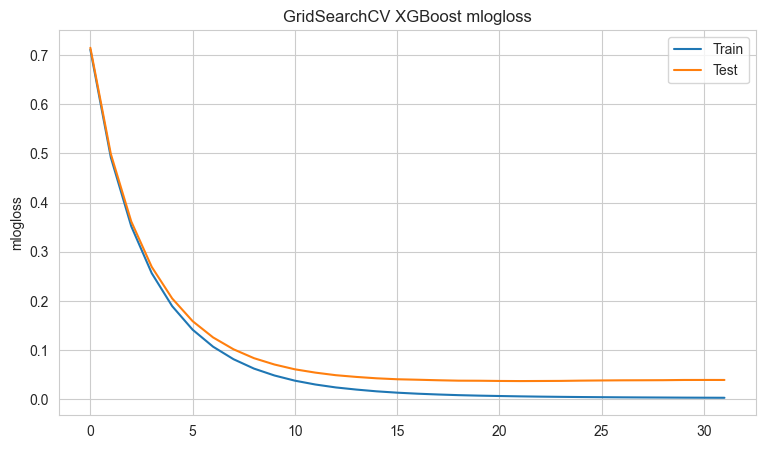

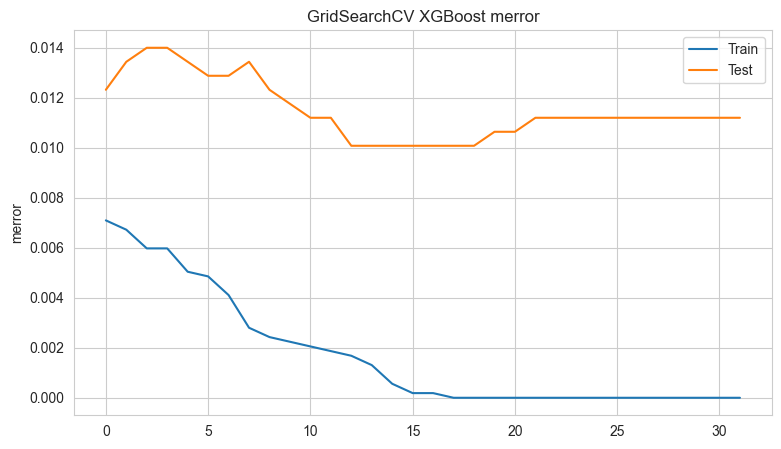


------------------ Confusion Matrix -----------------

[[1587    6    4]
 [   1  144    0]
 [   9    0   35]]

-------------------- Key Metrics --------------------

Accuracy: 0.99
Balanced Accuracy: 0.93

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.95
Macro Recall: 0.93
Macro F1-score: 0.94

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.96      0.99      0.98       145
           2       0.90      0.80      0.84        44

    accuracy                           0.99      1786
   macro avg       0.95      0.93      0.94      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [20]:
## ---------- XGBoost model v1 ----------
## base run of model with default hyperparameters

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

### XGBoost model v2

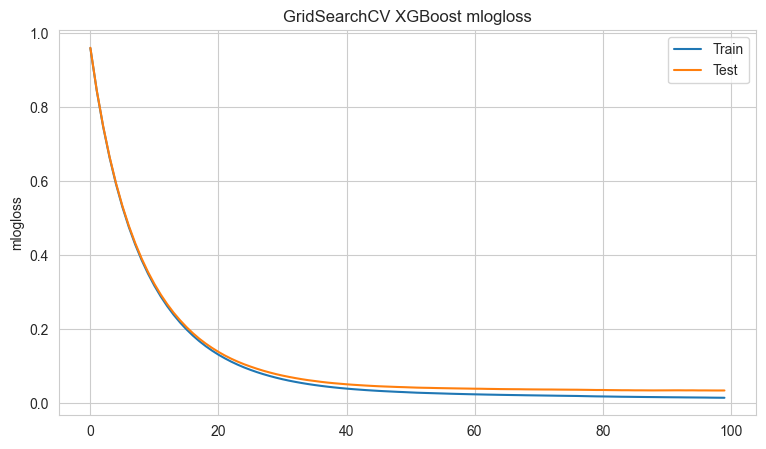

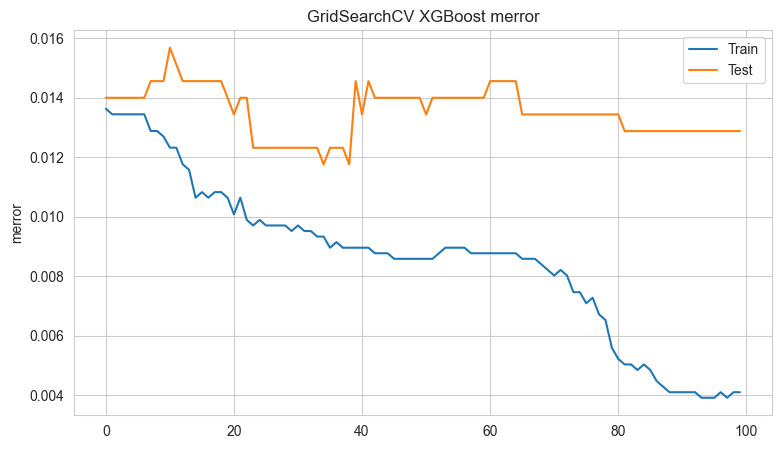


------------------ Confusion Matrix -----------------

[[1587    5    5]
 [   2  143    0]
 [  11    0   33]]

Accuracy: 0.99
Balanced Accuracy: 0.91

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.94
Macro Recall: 0.91
Macro F1-score: 0.92

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.97      0.99      0.98       145
           2       0.87      0.75      0.80        44

    accuracy                           0.99      1786
   macro avg       0.94      0.91      0.92      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [21]:
## ---------- XGBoost model v2 ----------
## second run of model with "optimized" hyperparameters 

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=1, # default L2 value
                            subsample=1, # default subsample value
                            colsample_bytree=1, # default colsample_bytree value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            #sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

### XGBoost Model v3

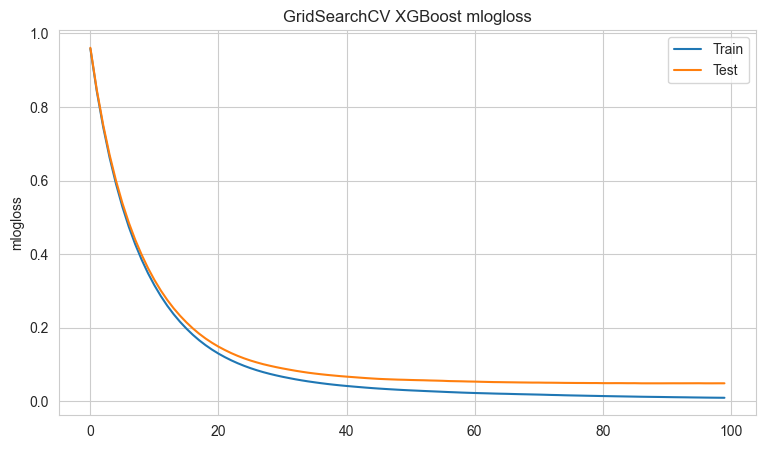

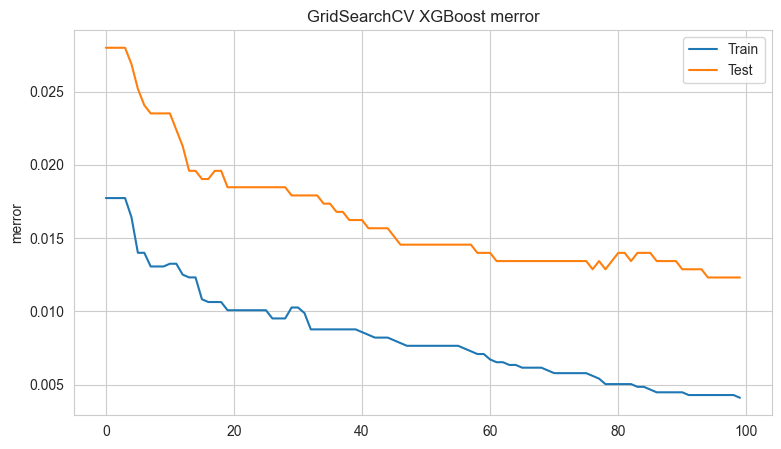


------------------ Confusion Matrix -----------------

[[1576    7   14]
 [   0  145    0]
 [   3    0   41]]

Accuracy: 0.99
Balanced Accuracy: 0.97

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.90
Macro Recall: 0.97
Macro F1-score: 0.93

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1597
           1       0.95      1.00      0.98       145
           2       0.75      0.93      0.83        44

    accuracy                           0.99      1786
   macro avg       0.90      0.97      0.93      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [22]:
## ---------- XGBoost model v3 ----------
## third run of model with "optimized" hyperparameters and
## attempting to treat unbalanced target classes

# balancing 'target' class weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=5, # re-optimized from v2
                            reg_lambda=1, # default L2 value
                            #subsample=0.8, # tried but not ideal
                            #colsample_bytree=0.3, # tried but not ideal
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

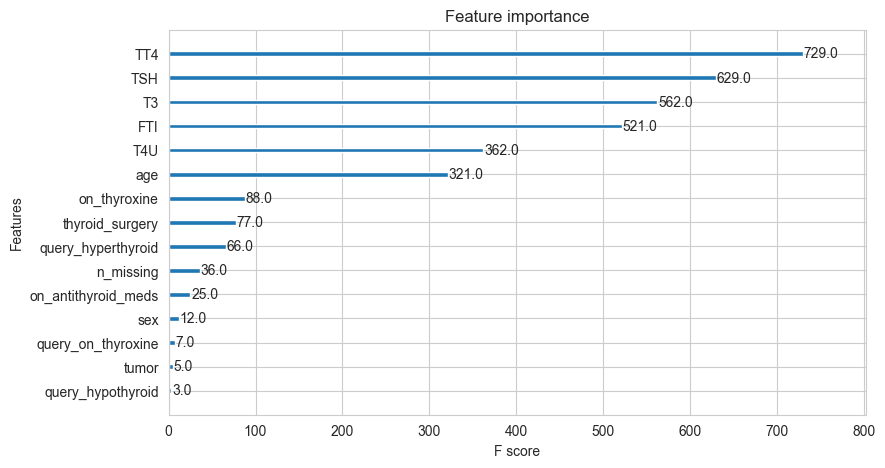

In [23]:
## ---------- Plot Feature Importance ----------
## plotting feature importance of best xgboost model (v3)

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf, ax=ax)
plt.show()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

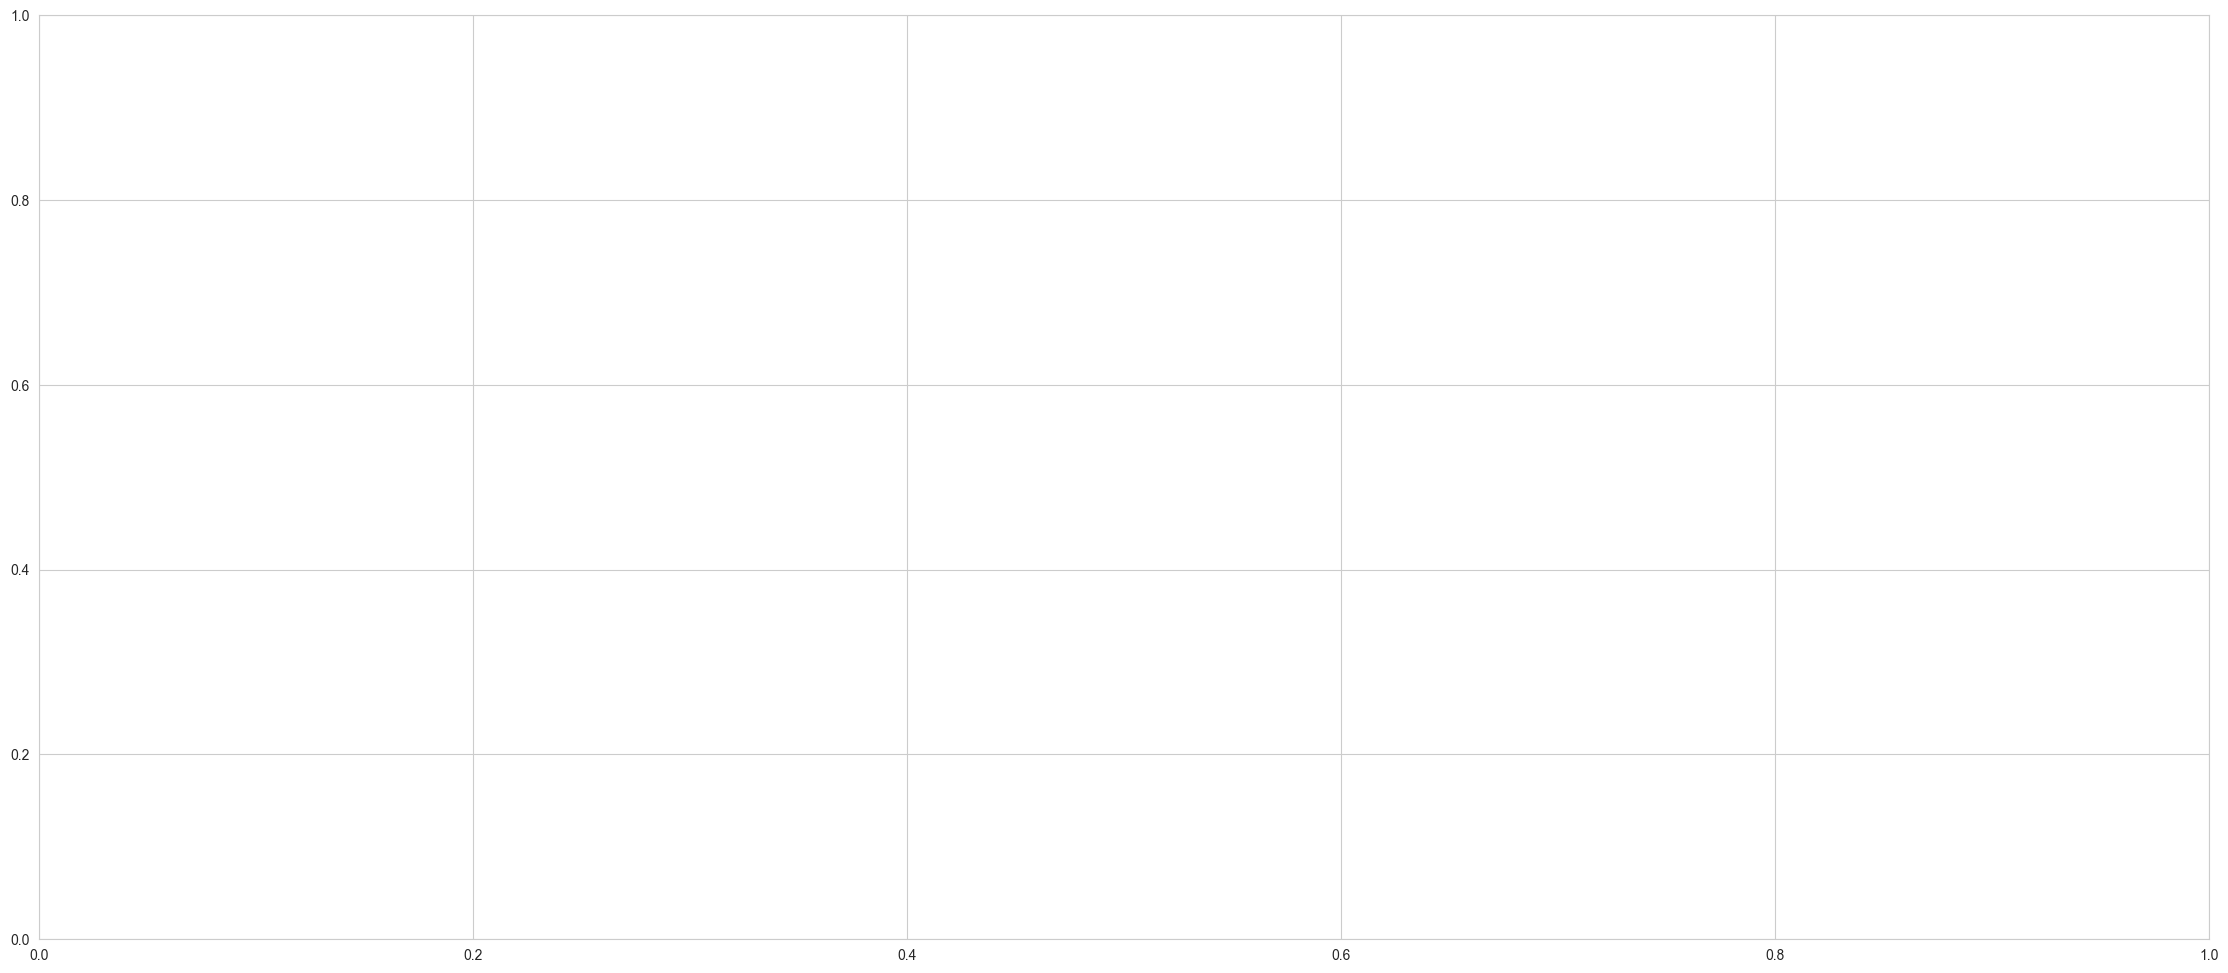

In [26]:
## ---------- Plot Model Tree ----------
## plotting model tree of best xgboost model (v3)

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 28,12
xgb.plot_tree(xgb_clf)
plt.show()

## Closing Arguments